# Optical Character Recignition and Text Similarity

In [114]:

#importing dependencies 

import cv2
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
from pytesseract import Output
import wikipedia
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#expand column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


## Instructions
Each block of the practical assignment has discussion questions and required actions, as well as cells, where you can write answers for the questions

####  <span style="color:green">??? Questions are marked in green </span>
####  <span style="color:DarkRed">!!! Action needed: Required actions are marked in dark red</span>

## Plan for today: 
- explore the Graph
- identify interesting books (editions)
- go through OCR pipeline steps (compare quality, identify problems and propose possible solutions)
- look into text similarity algorithms (in particular, TF-IDF)

## Graph Text-reuse Tool: Explore

#### <span style="color:DarkRed"> !!! Let's explore the interface of the tool here: </span>
https://graph-rare-books.ethz.ch - &#9200;<b>10 min</b>

Look at the description of the project, watch the Youtube video, follow the instructions on the page. 

####  <span style="color:green">??? What interesting editions have you found? </span>
####  <span style="color:green">??? What patterns in text reuse have you noticed? </span>
####  <span style="color:green">??? Give examples where algorithm picked up similarity right </span>
####  <span style="color:green">??? Give examples where algorithm picked up similarity wrong </span>



## Let's start with looking into selected pages from "M. Vitruvius per Iocundum solito castigatior factus cum figuris et tabula ut iam legi et intelligi possit" by Giocondo 

Let's look up what we can learn about the author with Wikipedia data

#### <span style="color:DarkRed"> !!! Change value of the "person" variable to look up Wikipedia summary for Fra Giocondo </span>



In [34]:
def get_summary_wikipedia(article):
    print(wikipedia.summary(article))
    
person="Giocondo"    
get_summary_wikipedia(person)

La Gioconda is an opera in four acts by Amilcare Ponchielli set to an Italian libretto by Arrigo Boito (as Tobia Gorrio), based on Angelo, Tyrant of Padua, a 1835 play in prose by Victor Hugo (the same source Gaetano Rossi had used for his libretto for Mercadante's Il giuramento in 1837).
First performed in 1876, La Gioconda was a major success for Ponchielli, as well as the most successful new Italian opera between Verdi's Aida (1871) and Otello (1887). It is also a famous example of the Italian genre of Grande opera, the equivalent of French Grand-Opéra.
Ponchielli revised the work three times, and the fourth and final version was first performed in 1879 in Genoa before reaching Milan in 1880 where its reputation as the definitive version was established. There are several complete recordings of the opera, and it is regularly performed, especially in Italy. It is one of only a few operas that features a principal role for each of the six major voice types. The opera also includes the

Let's get to a more elaborated entry:

In [35]:
def get_content_wikipedia(article):
    page = wikipedia.page(article)
    content = page.content
    print(content)
get_content_wikipedia(person)

La Gioconda is an opera in four acts by Amilcare Ponchielli set to an Italian libretto by Arrigo Boito (as Tobia Gorrio), based on Angelo, Tyrant of Padua, a 1835 play in prose by Victor Hugo (the same source Gaetano Rossi had used for his libretto for Mercadante's Il giuramento in 1837).
First performed in 1876, La Gioconda was a major success for Ponchielli, as well as the most successful new Italian opera between Verdi's Aida (1871) and Otello (1887). It is also a famous example of the Italian genre of Grande opera, the equivalent of French Grand-Opéra.
Ponchielli revised the work three times, and the fourth and final version was first performed in 1879 in Genoa before reaching Milan in 1880 where its reputation as the definitive version was established. There are several complete recordings of the opera, and it is regularly performed, especially in Italy. It is one of only a few operas that features a principal role for each of the six major voice types. The opera also includes the

####  <span style="color:green">??? Is there any information provided on the book (edition) of interest in the Wikipedia article</span>



### Let's see if we can find information on the particular edition by Giocondo

#### <span style="color:DarkRed"> !!! Change value of the "edition" variable to look up Wikipedia summary for the edition of interest in Wikipedia </span>

In [38]:
edition = "architectura"
get_summary_wikipedia(edition)

Architecture is the art and technique of designing and building, as distinguished from the skills associated with construction. It is both the process and the product of sketching, conceiving, planning, designing, and constructing buildings or other structures. The term comes from Latin  architectura; from Ancient Greek  ἀρχιτέκτων (arkhitéktōn) 'architect'; from  ἀρχι- (arkhi-) 'chief', and  τέκτων (téktōn) 'creator'. Architectural works, in the material form of buildings, are often perceived as cultural symbols and as works of art. Historical civilizations are often identified with their surviving architectural achievements.The practice, which began in the prehistoric era, has been used as a way of expressing culture for civilizations on all seven continents. For this reason, architecture is considered to be a form of art. Texts on architecture have been written since ancient times. The earliest surviving text on architectural theories is the 1st century AD treatise De architectura b

In [37]:
get_content_wikipedia(edition)

De architectura (On architecture, published as Ten Books on Architecture) is a treatise on architecture written by the Roman architect and military engineer Marcus Vitruvius Pollio and dedicated to his patron, the emperor Caesar Augustus, as a guide for building projects. As the only treatise on architecture to survive from antiquity, it has been regarded since the Renaissance as the first book on architectural theory, as well as a major source on the canon of classical architecture. It contains a variety of information on Greek and Roman buildings, as well as prescriptions for the planning and design of military camps, cities, and structures both large (aqueducts, buildings, baths, harbours) and small (machines, measuring devices, instruments).  Since Vitruvius published before the development of cross vaulting, domes, concrete, and other innovations associated with Imperial Roman architecture, his ten books give no information on these hallmarks of Roman building design and technolog

Space for your notes ...

### And here is the link to the book in the Graph https://graph-rare-books.ethz.ch/#/book/98c4d9e8-eef3-44c6-919a-d281fab33524?page=1
#### <span style="color:DarkRed"> !!! Let's explore this edition and connections </span> 
&#9200; <b> 5 min </b>



## Getting into OCR 

<b>Disclaimer</b>: We are going to reproduce a simplified OCR Pipeline, we are not using Google Cloud Vision (as in the Graph app) but an open-source OCR library - <b>Tesseract</b> and its Python wrapper - <b>pytesseract</b>. 
For text similarity detection we will be using a particular technique: TF-IDF, and not Passim as in the Graph Tool

### Here are the paths to page images of interest 
I chose the first page of the first book for simplicity, let's get started.

In [47]:
# paths_to_images
path_to_page_image_1552_info = "./images/Liber_primus_1552_info.tiff"
path_to_page_image_1511 = "./images/Liber_primus_1511.tiff"
path_to_page_image_1543 = "./images/Liber_primus_1543.tiff"
path_to_page_image_1552 = "./images/Liber_primus_1552.tiff"

### We begin with an easy example of OCR, which is an information page for one of the editions, since it is clean and clear image

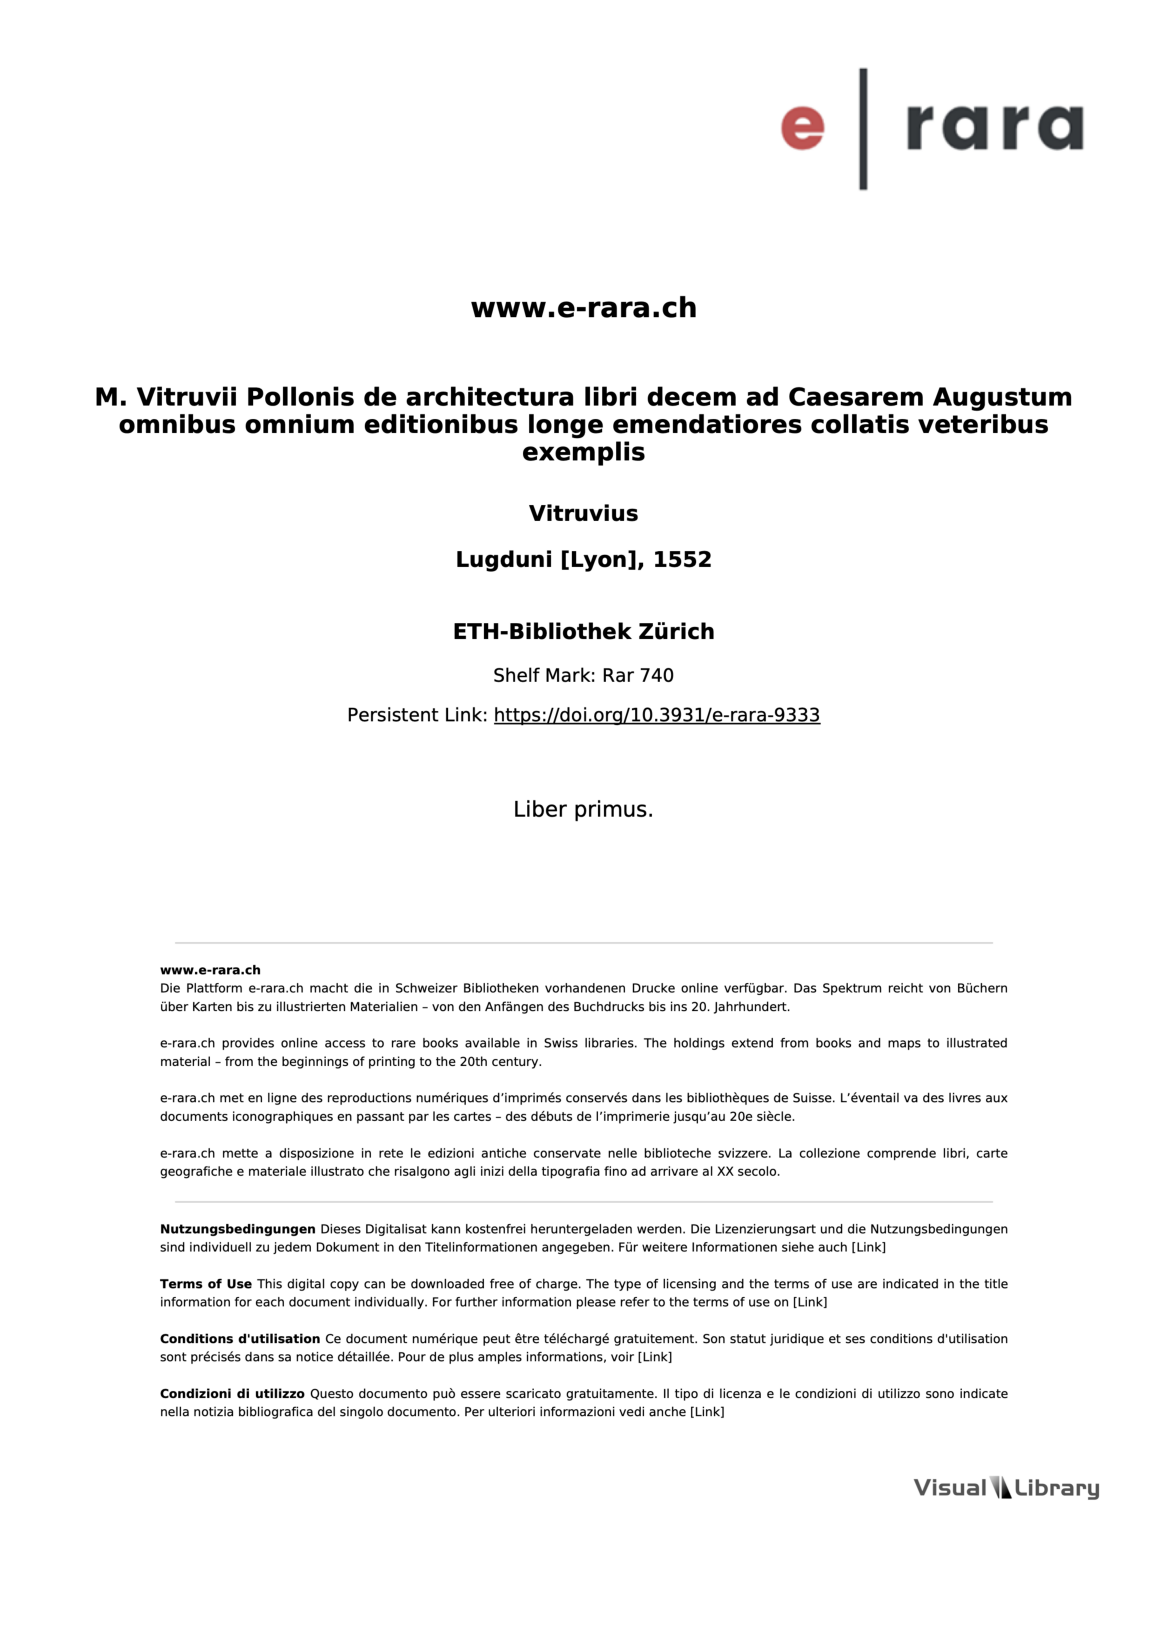

In [42]:
# this cell contains a function, which loads and displays the page image
def load_and_show_page_image(image_path):
    image = cv2.imread(image_path)
    plt.figure(figsize=(30, 30))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return(image)
# note that the function requires a path to the page image of interest
info_image =load_and_show_page_image(path_to_page_image_1552_info)    

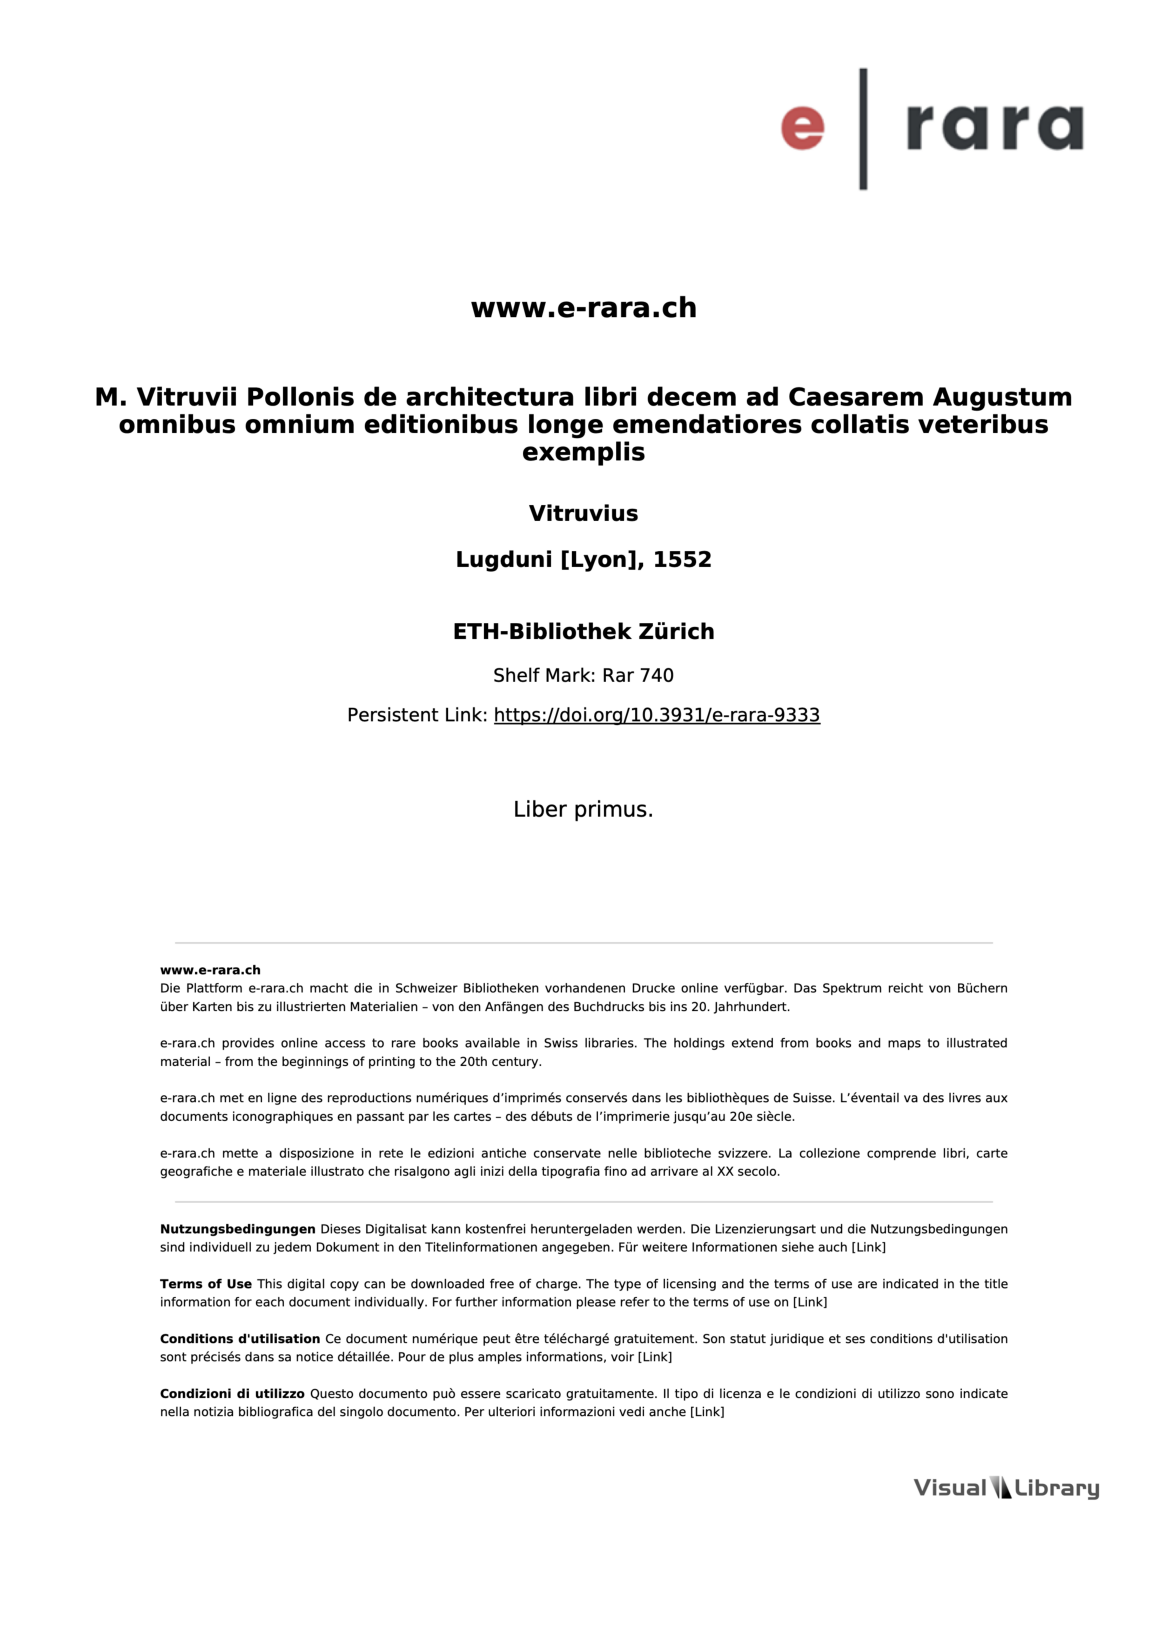

Extracted Text:
e | rara

www.e-rara.ch

M. Vitruvii Pollonis de architectura libri decem ad Caesarem Augustum
omnibus omnium editionibus longe emendatiores collatis veteribus
exemplis

Vitruvius

Lugduni [Lyon], 1552

ETH-Bibliothek Zurich
Shelf Mark: Rar 740
Persistent Link: https://doi.org/10.3931/e-rara-9333

Liber primus.

www.e-rara.ch
Die Plattform e-rara.ch macht die in Schweizer Bibliotheken vorhandenen Drucke online verfligbar. Das Spektrum reicht von Buchern
Uber Karten bis zu illustrierten Materialien - von den Anfangen des Buchdrucks bis ins 20. Jahrhundert.

e-rara.ch provides online access to rare books available in Swiss libraries. The holdings extend from books and maps to illustrated
material - from the beginnings of printing to the 20th century.

e-rara.ch met en ligne des reproductions numériques d’imprimés conservés dans les bibliothéques de Suisse. L’éventail va des livres aux
documents iconographiques en passant par les cartes - des débuts de I’imprimerie jusqu’a

"e | rara\n\nwww.e-rara.ch\n\nM. Vitruvii Pollonis de architectura libri decem ad Caesarem Augustum\nomnibus omnium editionibus longe emendatiores collatis veteribus\nexemplis\n\nVitruvius\n\nLugduni [Lyon], 1552\n\nETH-Bibliothek Zurich\nShelf Mark: Rar 740\nPersistent Link: https://doi.org/10.3931/e-rara-9333\n\nLiber primus.\n\nwww.e-rara.ch\nDie Plattform e-rara.ch macht die in Schweizer Bibliotheken vorhandenen Drucke online verfligbar. Das Spektrum reicht von Buchern\nUber Karten bis zu illustrierten Materialien - von den Anfangen des Buchdrucks bis ins 20. Jahrhundert.\n\ne-rara.ch provides online access to rare books available in Swiss libraries. The holdings extend from books and maps to illustrated\nmaterial - from the beginnings of printing to the 20th century.\n\ne-rara.ch met en ligne des reproductions numériques d’imprimés conservés dans les bibliothéques de Suisse. L’éventail va des livres aux\ndocuments iconographiques en passant par les cartes - des débuts de I’imprime

In [116]:
def ocr_page_image(image):
    plt.figure(figsize=(30, 30))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
# Perform OCR using Tesseract
    text = pytesseract.image_to_string(image)
    # Display the extracted text
    print("Extracted Text:")
    print(text)
    return text
ocr_page_image(image)

### Let us look at three of those pages and compare them by close reading/looking &#128269; &#128214;

#### <span style="color:DarkRed"> !!! Fill in the list "image_paths" with the variables, which contain paths to page images </span>

In [51]:
image_paths = []
def load_and_show_multiple_page_images(image_paths):
    images = [] 
    # Load the images
    for path in image_paths:
        image = cv2.imread(path)
        images.append(image)
    
    # Display the images in separate windows
    for i, image in enumerate(images):
        cv2.namedWindow(f"Image {i+1}", cv2.WINDOW_NORMAL)
        cv2.imshow(f"Image {i+1}", image)
    
    # Wait for a key press to close the windows
    cv2.startWindowThread()
    print(cv2.waitKey(0))
    cv2.destroyAllWindows()
    for i in range(2):
        cv2.waitKey(1)
    
    return images
load_and_show_multiple_page_images(image_paths)

27


[array([[[ 63,  66,  69],
         [ 63,  66,  69],
         [ 63,  65,  69],
         ...,
         [ 60,  61,  62],
         [ 59,  61,  61],
         [ 59,  61,  61]],
 
        [[ 63,  65,  69],
         [ 63,  64,  69],
         [ 63,  64,  69],
         ...,
         [ 60,  61,  62],
         [ 59,  61,  61],
         [ 59,  61,  61]],
 
        [[ 62,  64,  68],
         [ 62,  63,  68],
         [ 61,  63,  67],
         ...,
         [ 60,  61,  62],
         [ 60,  62,  62],
         [ 60,  62,  62]],
 
        ...,
 
        [[ 57,  57,  57],
         [ 57,  57,  57],
         [ 57,  57,  57],
         ...,
         [ 57,  55,  57],
         [ 55,  54,  55],
         [ 55,  54,  55]],
 
        [[ 57,  57,  57],
         [ 57,  57,  57],
         [ 57,  57,  57],
         ...,
         [ 57,  55,  57],
         [ 55,  54,  55],
         [ 55,  54,  55]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

<b>NB</b> To exit the pop up windows, press "Esc" button

#### Let's look into internal work of OCR

In [57]:
def show_boxes(image_path):
    # Preprocess the image
    image = cv2.imread(image_path)
    
    # Perform OCR using pytesseract
    # Perform OCR using pytesseract and get the bounding box information
    data = pytesseract.image_to_boxes(image, output_type=pytesseract.Output.DICT)
    # Get the bounding box coordinates
    boxes = data['char']
    left_coords = data['left']
    bottom_coords = data['bottom']
    right_coords = data['right']
    top_coords = data['top']

    # Draw rectangles on the image using the bounding box coordinates
    for box, left, bottom, right, top in zip(boxes, left_coords, bottom_coords, right_coords, top_coords):
        x, y, w, h = int(left), image.shape[0] - int(top), int(right) - int(left), int(top) - int(bottom)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with the drawn boxes
    cv2.imshow("Image with Boxes", image)
    cv2.startWindowThread()
    print(cv2.waitKey(0))
    cv2.destroyAllWindows()
    for i in range(2):
        cv2.waitKey(1)



In [66]:
def show_values(image_path):
    # Preprocess the image
    image = cv2.imread(image_path)
    
    # Perform OCR using pytesseract
    # Perform OCR using pytesseract and get the bounding box information
    data = pytesseract.image_to_boxes(image, output_type=pytesseract.Output.DICT)
    print("Data Structure:")
    for key in data.keys():
        print(key)
    print("Sample values:")
    for key, value in data.items():
        if len(value) > 0:
            sample_value = value[0]
            print(f"Sample value for key '{key}': {sample_value}")

#### <span style="color:DarkRed"> !!! Insert the path to image page of interest into the brackets</span>

In [59]:
show_boxes()

{'char': ['~', '-', 'M', '.', 'V', 'I', 'T', 'R', 'V', 'V', 'I', 'I', 'D', 'E', 'A', 'R', 'C', 'H', 'I', 'T', 'E', 'C', 'T', 'V', 'R', 'A', 'L', 'I', 'B', 'E', 'R', 'P', 'R', 'I', 'M', 'V', 'S', '.', 'V', 'M', 'd', 'i', 'u', 'i', 'n', 'a', 'm', 'e', 'n', 's', 't', 'u', 'a', '&', 'n', 'u', 'm', 'e', 'n', 'i', 'm', 'p', 'e', 'r', 'a', 't', 'o', 'r', 'C', 'x', '/', 'f', 'a', 'r', 'i', 'm', 'p', 'e', 'r', 'i', 'o', 'p', 'o', 't', 'i', 'r', 'e', 't', 'u', 'r', 'o', 'r', 'b', 'i', 's', 't', 'e', 'r', 'r', 'a', 'r', 'u', 'm', ',', 'i', 'n', 'u', 'i', 'c', 't', 'a', 'g', 's', 'v', 'i', 'r', 't', 'u', 't', 'e', 'c', 'u', 'n', 'é', 't', 'i', 's', 'h', 'o', 'f', 't', 'i', 'b', 'u', 's', 'f', 't', 'r', 'a', 't', 'i', 's', ',', 't', 'r', 'r', 'i', 'u', 'm', 'p', 'h', 'o', 'v', 'i', 's', 'G', 'o', 'r', 'i', 'a', 'g', 't', 'u', 'a', 'c', 'i', 'u', 'e', 's', 'g', 'l', 'o', 'r', 'i', 'a', 'r', 'e', 'n', 't', 'u', 'r', ',', '&', 'g', 'é', 't', 'e', 's', 'o', 'm', 'n', 'e', 's', 'f', 'u', 'b', 'a', 'é', 

27


In [67]:
show_values()

Data Structure:
char
left
bottom
right
top
page
Sample values:
Sample value for key 'char': ~
Sample value for key 'left': 0
Sample value for key 'bottom': 1
Sample value for key 'right': 2540
Sample value for key 'top': 65
Sample value for key 'page': 0


#### Let us pre-process images to make them more accessible for OCR

In [98]:
import cv2
import numpy as np

def denoise_image(image_path):
    image = cv2.imread(image_path)
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    
    # Concatenate original and denoised images horizontally
    concatenated_image = np.hstack((image, denoised_image))
    
    # Display the concatenated image
    cv2.imshow("Original vs Denoised", concatenated_image)
    cv2.startWindowThread()
    print(cv2.waitKey(0))
    cv2.destroyAllWindows()
    for i in range(2):
        cv2.waitKey(1)
    
    return denoised_image

def adjust_color(image_path):
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Concatenate original and color-adjusted images horizontally
    concatenated_image = np.hstack((image, cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)))
    
    # Display the concatenated image
    cv2.imshow("Original vs Color Adjusted", concatenated_image)
    cv2.startWindowThread()
    print(cv2.waitKey(0))
    cv2.destroyAllWindows()
    for i in range(2):
        cv2.waitKey(1)
        
    return gray_image

def binarize_image(image_path):
    image = cv2.imread(image_path)
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    gray_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2GRAY)
    _, binarized_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Concatenate original and binarized images horizontally
    concatenated_image = np.hstack((image, cv2.cvtColor(binarized_image, cv2.COLOR_GRAY2BGR)))
    
    # Display the concatenated image
    cv2.imshow("Original vs Binarized", concatenated_image)
    cv2.startWindowThread()
    print(cv2.waitKey(0))
    cv2.destroyAllWindows()
    for i in range(2):
        cv2.waitKey(1)
        
    return binarized_image


In [88]:
denoise_image(path_to_page_image_1543)


27


array([[[182, 202, 218],
        [182, 202, 218],
        [182, 202, 218],
        ...,
        [185, 202, 217],
        [185, 202, 217],
        [185, 202, 217]],

       [[182, 202, 218],
        [182, 202, 218],
        [182, 202, 218],
        ...,
        [185, 202, 217],
        [185, 202, 217],
        [185, 202, 217]],

       [[182, 202, 218],
        [182, 202, 218],
        [182, 202, 218],
        ...,
        [185, 202, 217],
        [185, 202, 217],
        [185, 202, 217]],

       ...,

       [[186, 201, 221],
        [186, 201, 221],
        [186, 201, 221],
        ...,
        [182, 202, 218],
        [182, 202, 218],
        [182, 202, 218]],

       [[186, 201, 221],
        [186, 201, 221],
        [186, 201, 221],
        ...,
        [182, 202, 218],
        [182, 202, 218],
        [182, 202, 218]],

       [[186, 201, 221],
        [186, 201, 221],
        [186, 201, 221],
        ...,
        [182, 202, 218],
        [182, 202, 218],
        [182, 202, 218]]

In [89]:
adjust_color(path_to_page_image_1543)

27


array([[205, 205, 205, ..., 206, 206, 206],
       [205, 205, 205, ..., 206, 206, 206],
       [205, 205, 205, ..., 206, 206, 206],
       ...,
       [207, 207, 207, ..., 205, 205, 205],
       [205, 205, 205, ..., 205, 205, 205],
       [205, 205, 205, ..., 205, 205, 205]], dtype=uint8)

In [118]:
binarized_1511 = binarize_image(path_to_page_image_1511)

27


<b>NB</b> Make sure to press "Esc" button to proceed with the code

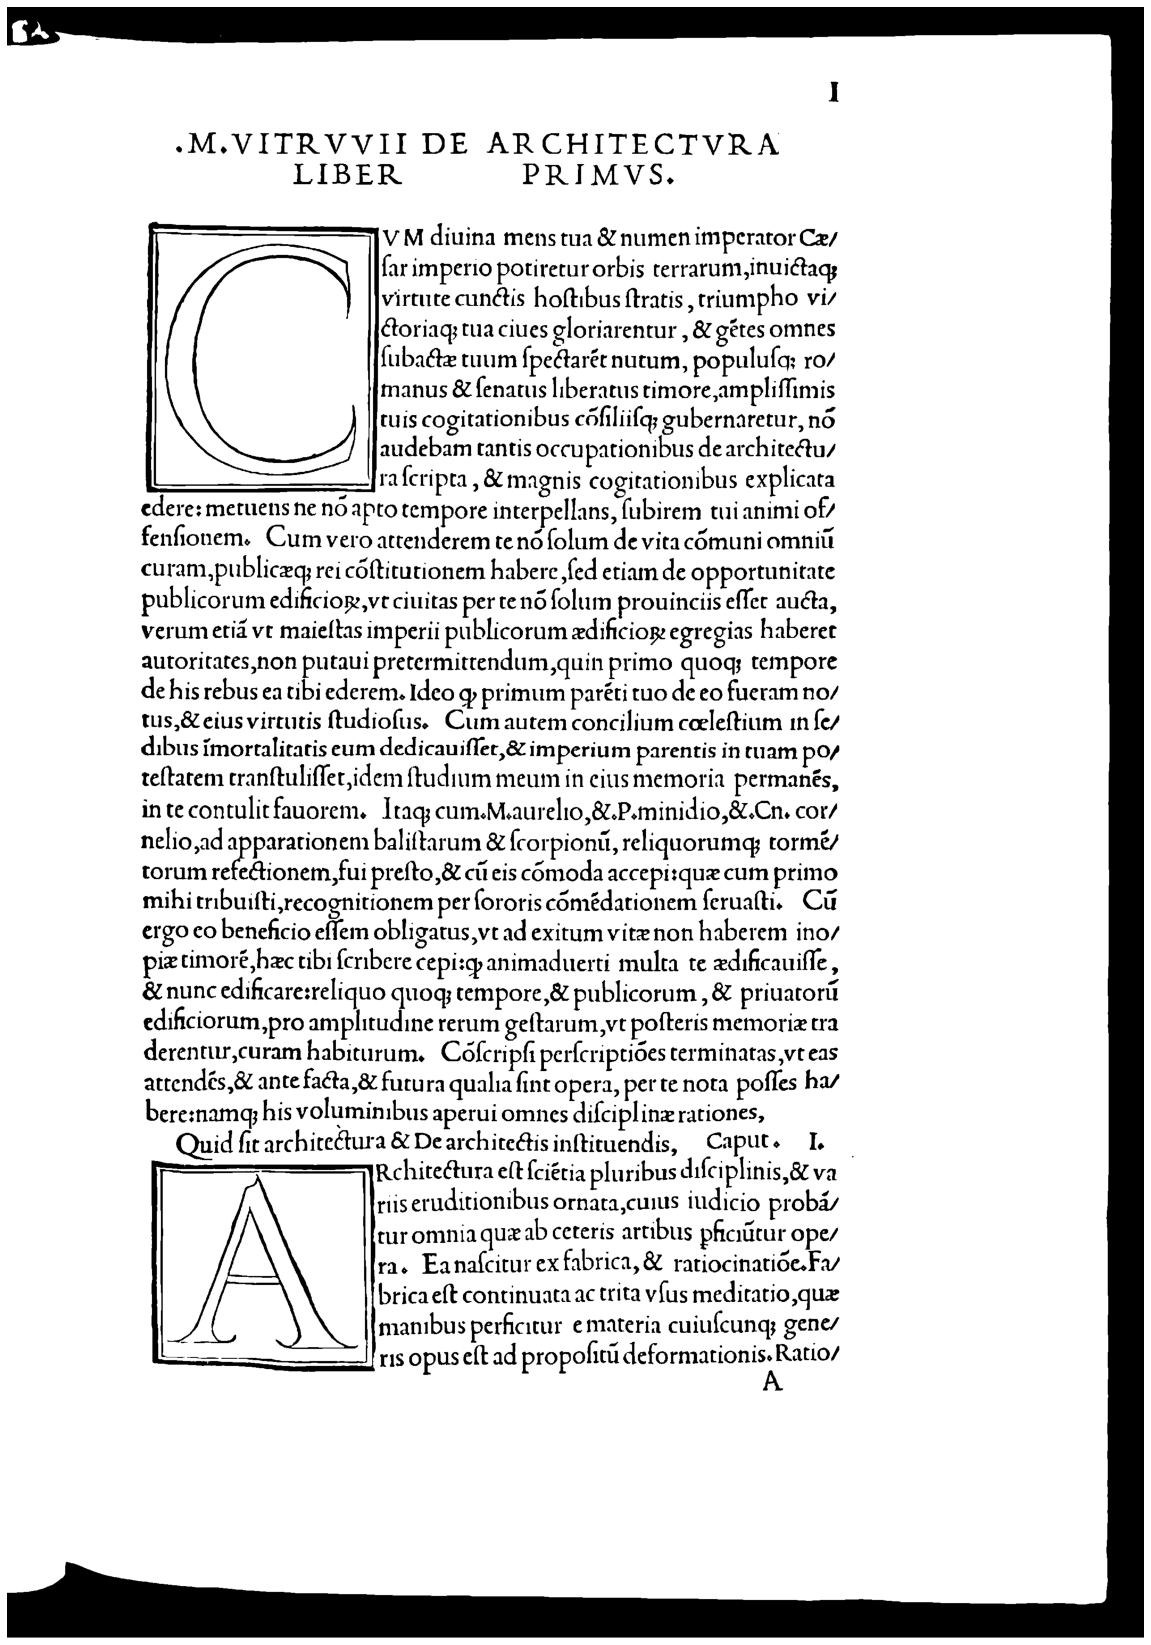

Extracted Text:
»-M.VITRVVII DE ARCHITECTVRA
LIBER PRIMVS.

VM diuina mens tua & numen imperator Cz/

far imperio potiretur orbis terrarum,inui@agg

virtue cunétis hoftibus ftratis , triumpho vis

Coriag tua ciues gloriarentur , & gétes omnes

{uba@e tuum fpeftarée nutum, populufa; ro/

manus & fenatus liberatus timore,ampliffimis

tuis cogitationibus cofiliifq; gubernaretur, nd

audebam tantis occupationibus de archite@us

—}rafcripta , & magnis cogitationibus explicata

edere: metuens ne no apto tempore interpellans, {ubirem tui animi off

fenfionem. Cum vero attenderem ten6 folum de vitac6muni omnitt

curam, publica rei c6ftitutionem habere fed etiam de opportunitate

publicorum edificioge,ve ciuitas per tend folum prouinciis effec auéta,

verum etia ve maieftas imperii publicorum edificiox egregias haberet

autoritates,non putaui precermittendum,quin primo quog; tempore

de his rebus ea tibi ederem. Ideo q primum paréti tuo de eo fueram nos

tus,& eiusvirtutis Qtudiofus. Cum autem 

In [103]:
ocred_1511 = ocr_page_image(binarized_1511)
ocred_1511

#### <span style="color:DarkRed"> !!! Proceed with performing binarization and ocr of two other images</span>
Follow the code example:

binarized_1511 = binarize_image(path_to_page_image_1511)
ocred_1511 = ocr_page_image(binarized_1511)
ocred_1511


#### For the page from edition of 1543 use the following path: <b> path_to_page_image_1543 </b>

In [119]:
binarized_1543 = binarize_image(path_to_page_image_1543)


27


<b>NB</b> Make sure to press "Esc" button to proceed with the code

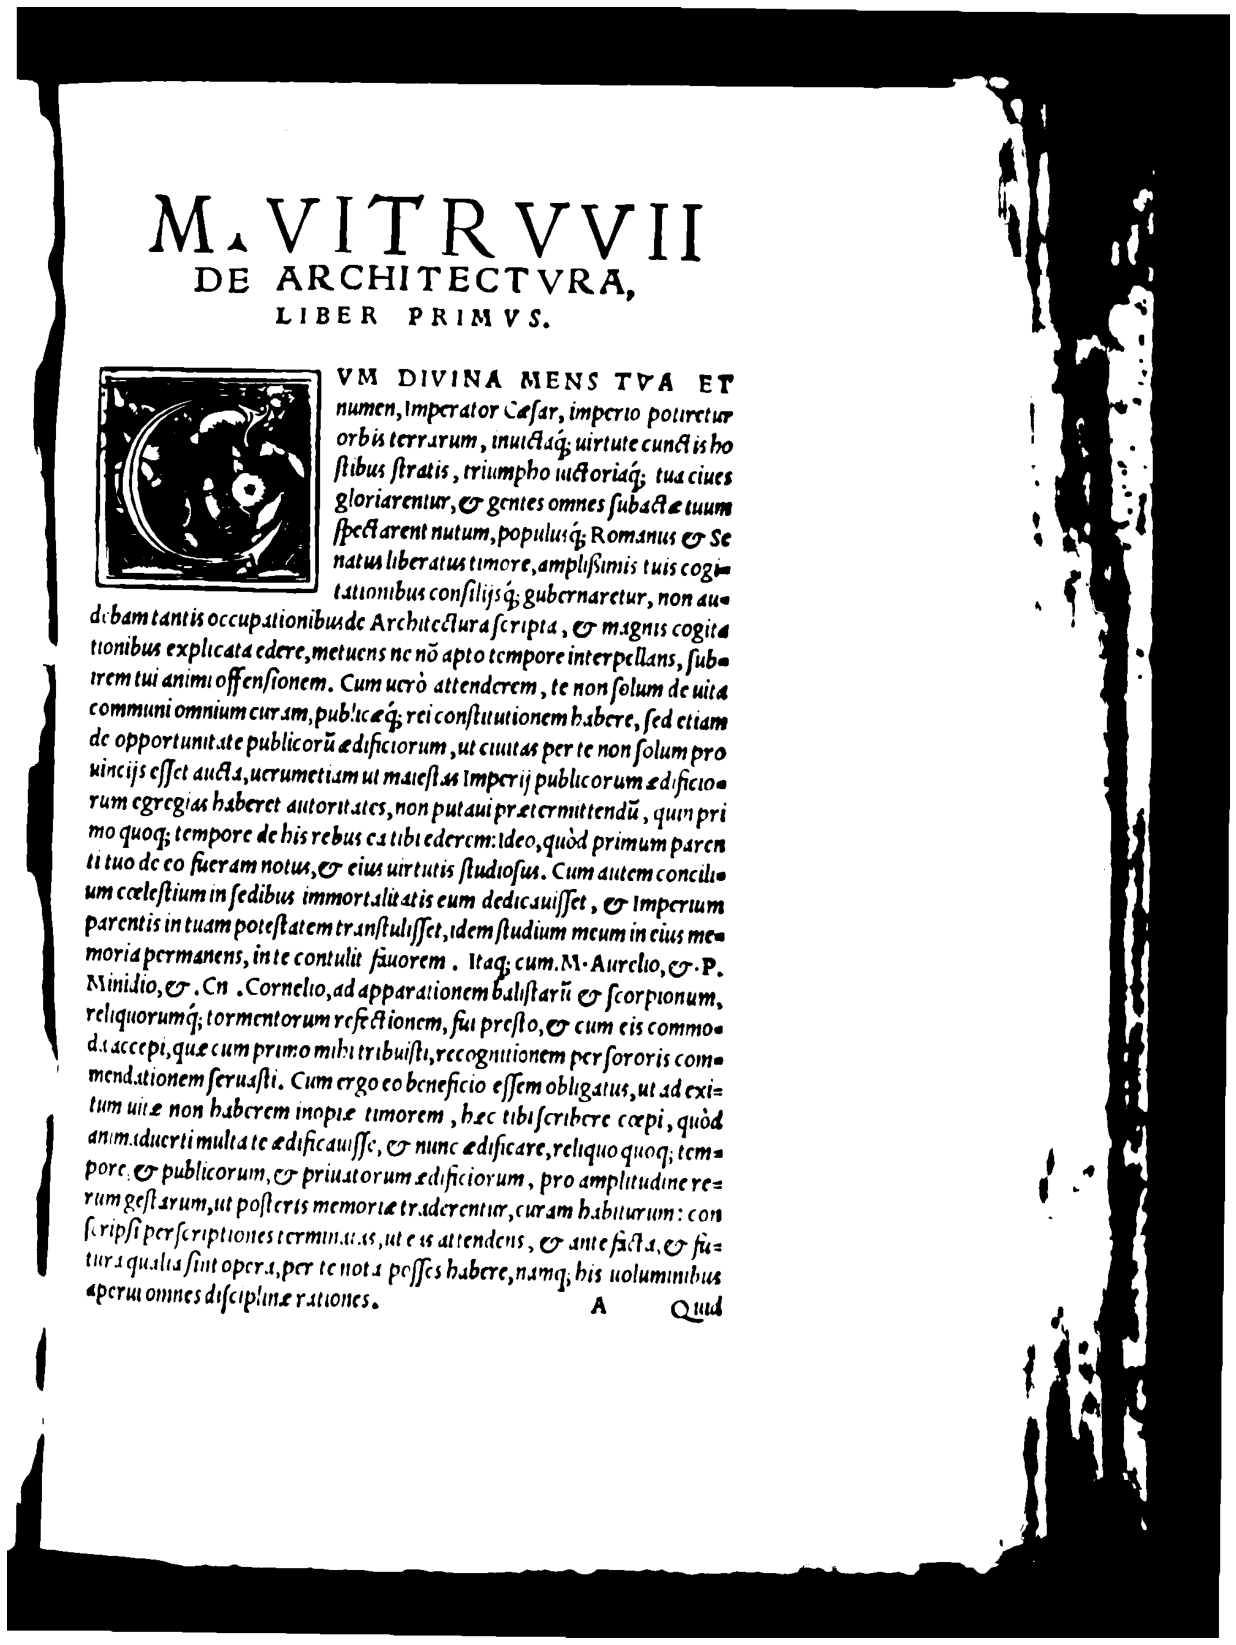

Extracted Text:
M.VITRVVII

DE ARCHITECTVRA,
LIBER PRIMVS,

VM DIVINA MENS TVA EP
numen, Imperator Cafar, impcrio potirctur
orbis terrarum, inuidag, uirtute cund is ho
flibus ftratis , rriumpbo woriag, tus ciues
gloriarentur, er gentes omnes fubste tuum
fbeA arent nutum, populusg; Romanus e Se
natus liberatus timore,amplifimis tuis cogbe
tatconibus con/ilijsg; gubernaretur, non aue
dcbam tantis occupationibusde Architellura [cripta , oF magnis cogita
tionibus explicata edere,metuens ne nd apto tempore interpcllans, fube
trem tut animioffenfionem, Cum ucro attendcrem, te non folum de uita
COMMUni Omnium cursm, publiceg, reiconftuutionem babere, fed ctiam
de opportunttate publicori edificiorum ,ut cuutas per tenon folum pro
mincijs effet auAs,ucrumetism ul matcfl.ss Imperij publicorum edificioe
rum egregias haberct autorit.stes,non putaui pretermittendiz, quin pri
mo quoq; tempore de his rebus ca tibtedercm: tdeo,quod primum paren
tituo deco fseram notus,er cius uirtutis ftudtofus. Cum a

'M.VITRVVII\n\nDE ARCHITECTVRA,\nLIBER PRIMVS,\n\nVM DIVINA MENS TVA EP\nnumen, Imperator Cafar, impcrio potirctur\norbis terrarum, inuidag, uirtute cund is ho\nflibus ftratis , rriumpbo woriag, tus ciues\ngloriarentur, er gentes omnes fubste tuum\nfbeA arent nutum, populusg; Romanus e Se\nnatus liberatus timore,amplifimis tuis cogbe\ntatconibus con/ilijsg; gubernaretur, non aue\ndcbam tantis occupationibusde Architellura [cripta , oF magnis cogita\ntionibus explicata edere,metuens ne nd apto tempore interpcllans, fube\ntrem tut animioffenfionem, Cum ucro attendcrem, te non folum de uita\nCOMMUni Omnium cursm, publiceg, reiconftuutionem babere, fed ctiam\nde opportunttate publicori edificiorum ,ut cuutas per tenon folum pro\nmincijs effet auAs,ucrumetism ul matcfl.ss Imperij publicorum edificioe\nrum egregias haberct autorit.stes,non putaui pretermittendiz, quin pri\nmo quoq; tempore de his rebus ca tibtedercm: tdeo,quod primum paren\ntituo deco fseram notus,er cius uirtutis ftudtofus.

In [120]:
ocred_1543 = ocr_page_image(binarized_1543)
ocred_1543

In [ ]:
#### For the page from edition of 1552 use the following path: <b> path_to_page_image_1552 </b>

In [124]:
binarized_1552 = binarize_image(path_to_page_image_1552)

27


<b>NB</b> Make sure to press "Esc" button to proceed with the code

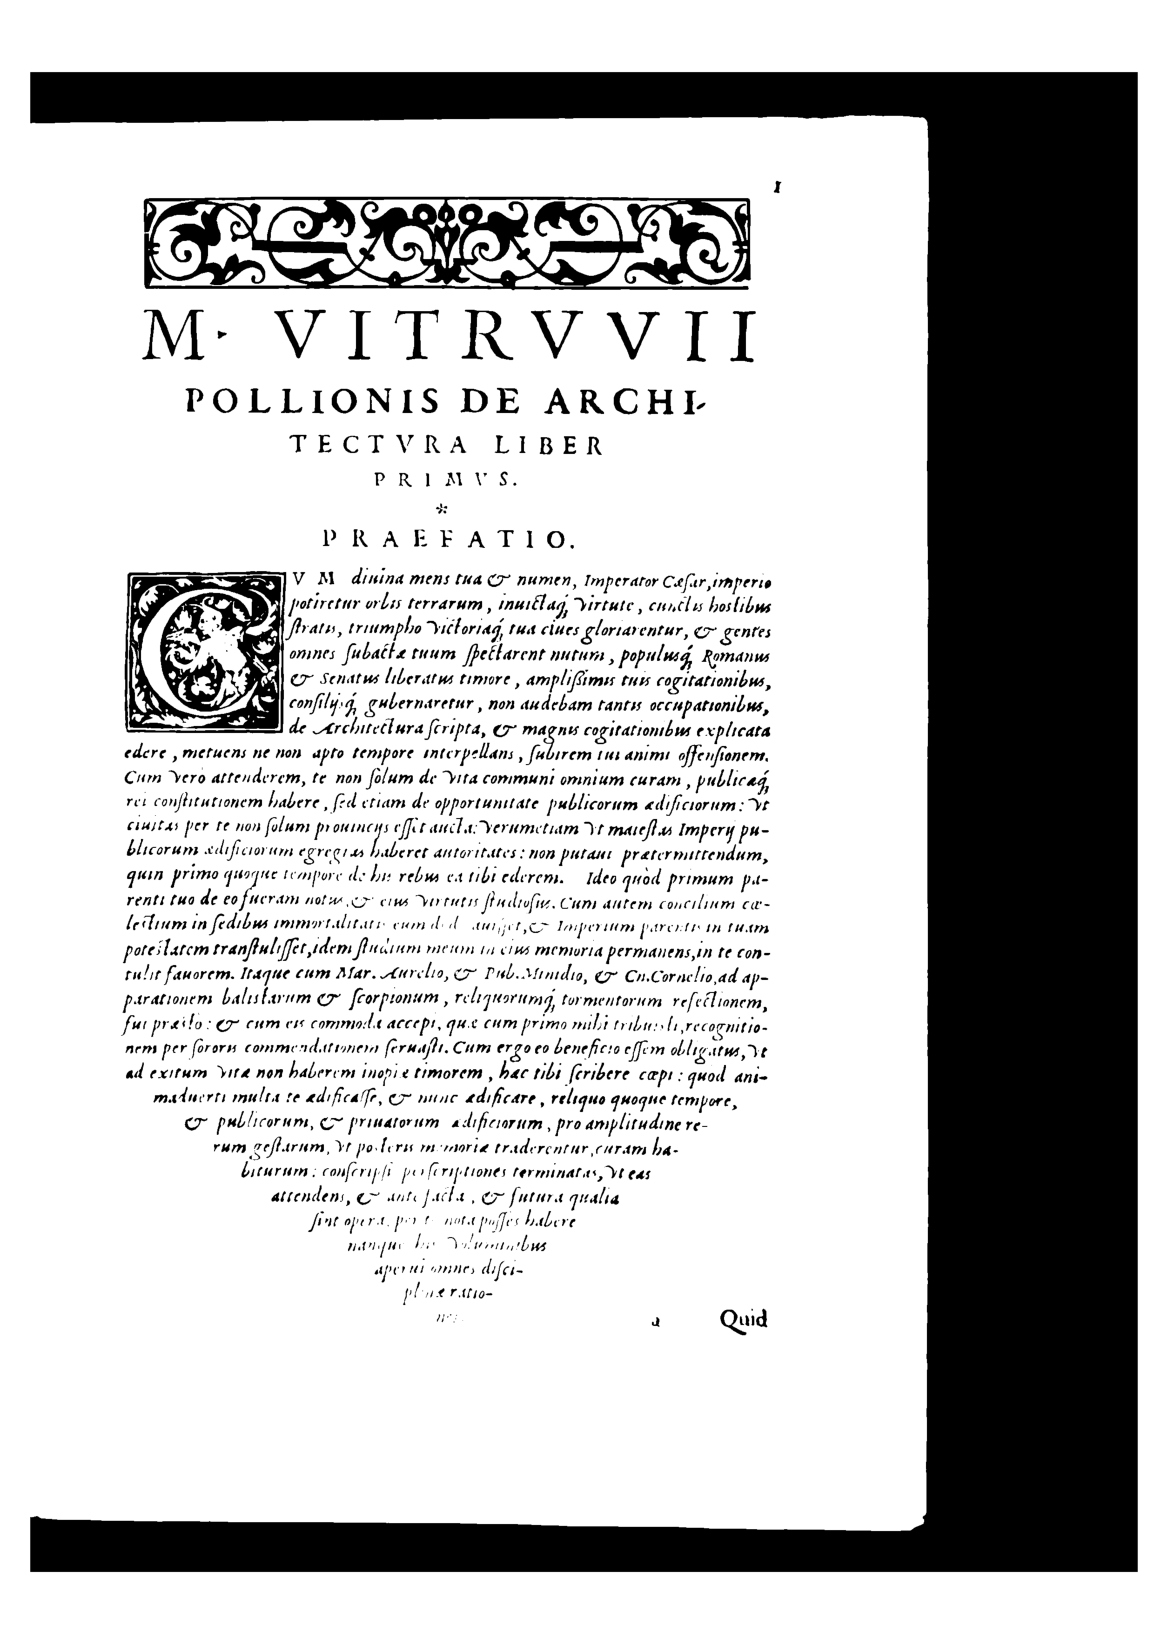

Extracted Text:
M- VITRVVII

POLLIONIS DE ARCHIL

TECTVRA LIBER
PRIMVS.

7

PRAEFATIO.

VM dinina mens tua (7 numen, Imperator Cafar,imperte
D potiretur orlss terrarum , inuslag Virtute , cunts hostibws
Oa rats, triuumpho Vitloriag, tua clues floriaventur, gentes
Yel omnes fubatte tuum fpettarent nutum , populusg Romanus
4 ex Senatus liberatus timore , amplifeimus tus cogutationibus,
Nad) confilysg, gubernaretur , non audebam tants occupationibus,
ele | de ar chitellura feripta, magn cogitatrombus explicate
edere , metuens ne non apto tempore snterpellans , fabirem tu animi offenfionem.
Cum Vero attendcrem, te non folum de Vita communi omnium curam , publicag
res conflututionem habere , fed etiam de opportunttate publicorum adificiorum: Yt
cinstas per re non folum p muineys offer atcha: Yerumctiam Vt mavefly Impery pu-
blicorum adificiorum egregr as haberet antaritates: non putaut pretcrmuttendum,
qauin primo qibag ne tempore de hi: rebws ca ibe ederem. Ideo quod primum pe-
rentt tuo d

'M- VITRVVII\n\nPOLLIONIS DE ARCHIL\n\nTECTVRA LIBER\nPRIMVS.\n\n7\n\nPRAEFATIO.\n\nVM dinina mens tua (7 numen, Imperator Cafar,imperte\nD potiretur orlss terrarum , inuslag Virtute , cunts hostibws\nOa rats, triuumpho Vitloriag, tua clues floriaventur, gentes\nYel omnes fubatte tuum fpettarent nutum , populusg Romanus\n4 ex Senatus liberatus timore , amplifeimus tus cogutationibus,\nNad) confilysg, gubernaretur , non audebam tants occupationibus,\nele | de ar chitellura feripta, magn cogitatrombus explicate\nedere , metuens ne non apto tempore snterpellans , fabirem tu animi offenfionem.\nCum Vero attendcrem, te non folum de Vita communi omnium curam , publicag\nres conflututionem habere , fed etiam de opportunttate publicorum adificiorum: Yt\ncinstas per re non folum p muineys offer atcha: Yerumctiam Vt mavefly Impery pu-\nblicorum adificiorum egregr as haberet antaritates: non putaut pretcrmuttendum,\nqauin primo qibag ne tempore de hi: rebws ca ibe ederem. Ideo quod primum pe-\nre

In [125]:
ocred_1552 = ocr_page_image(binarized_1552)
ocred_1552 

## Let's compare OCRed text to see how similar they are with TF-IDF algorithm


In [130]:
def compare_docs(image_1, image_2): 
    text1 = ocr_page_image(image_1)
    text2 = ocr_page_image(image_2)

    # Perform TF-IDF on the extracted text
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])

    # Compute cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)

    # Print the similarity score between the texts
    similarity_score = similarity_matrix[0][1]
    print("TF-IDF Similarity Score: {:.2%}".format(similarity_score))

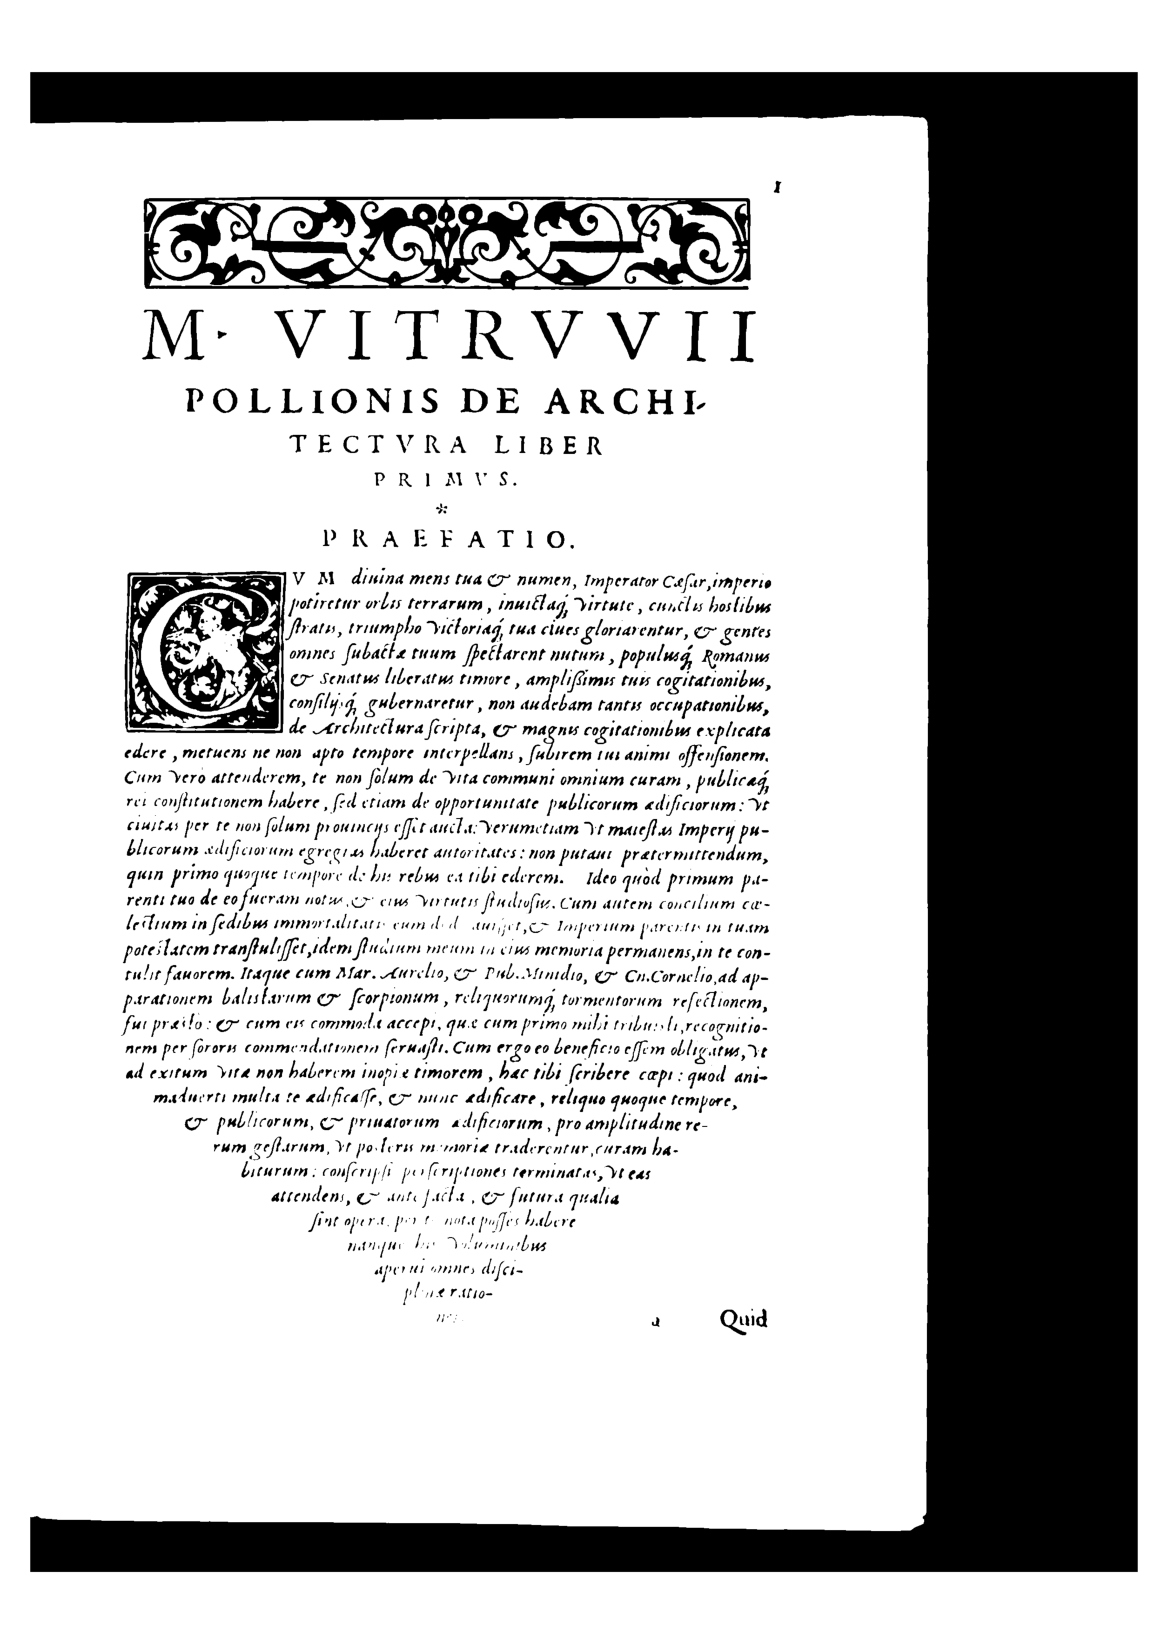

Extracted Text:
M- VITRVVII

POLLIONIS DE ARCHIL

TECTVRA LIBER
PRIMVS.

7

PRAEFATIO.

VM dinina mens tua (7 numen, Imperator Cafar,imperte
D potiretur orlss terrarum , inuslag Virtute , cunts hostibws
Oa rats, triuumpho Vitloriag, tua clues floriaventur, gentes
Yel omnes fubatte tuum fpettarent nutum , populusg Romanus
4 ex Senatus liberatus timore , amplifeimus tus cogutationibus,
Nad) confilysg, gubernaretur , non audebam tants occupationibus,
ele | de ar chitellura feripta, magn cogitatrombus explicate
edere , metuens ne non apto tempore snterpellans , fabirem tu animi offenfionem.
Cum Vero attendcrem, te non folum de Vita communi omnium curam , publicag
res conflututionem habere , fed etiam de opportunttate publicorum adificiorum: Yt
cinstas per re non folum p muineys offer atcha: Yerumctiam Vt mavefly Impery pu-
blicorum adificiorum egregr as haberet antaritates: non putaut pretcrmuttendum,
qauin primo qibag ne tempore de hi: rebws ca ibe ederem. Ideo quod primum pe-
rentt tuo d

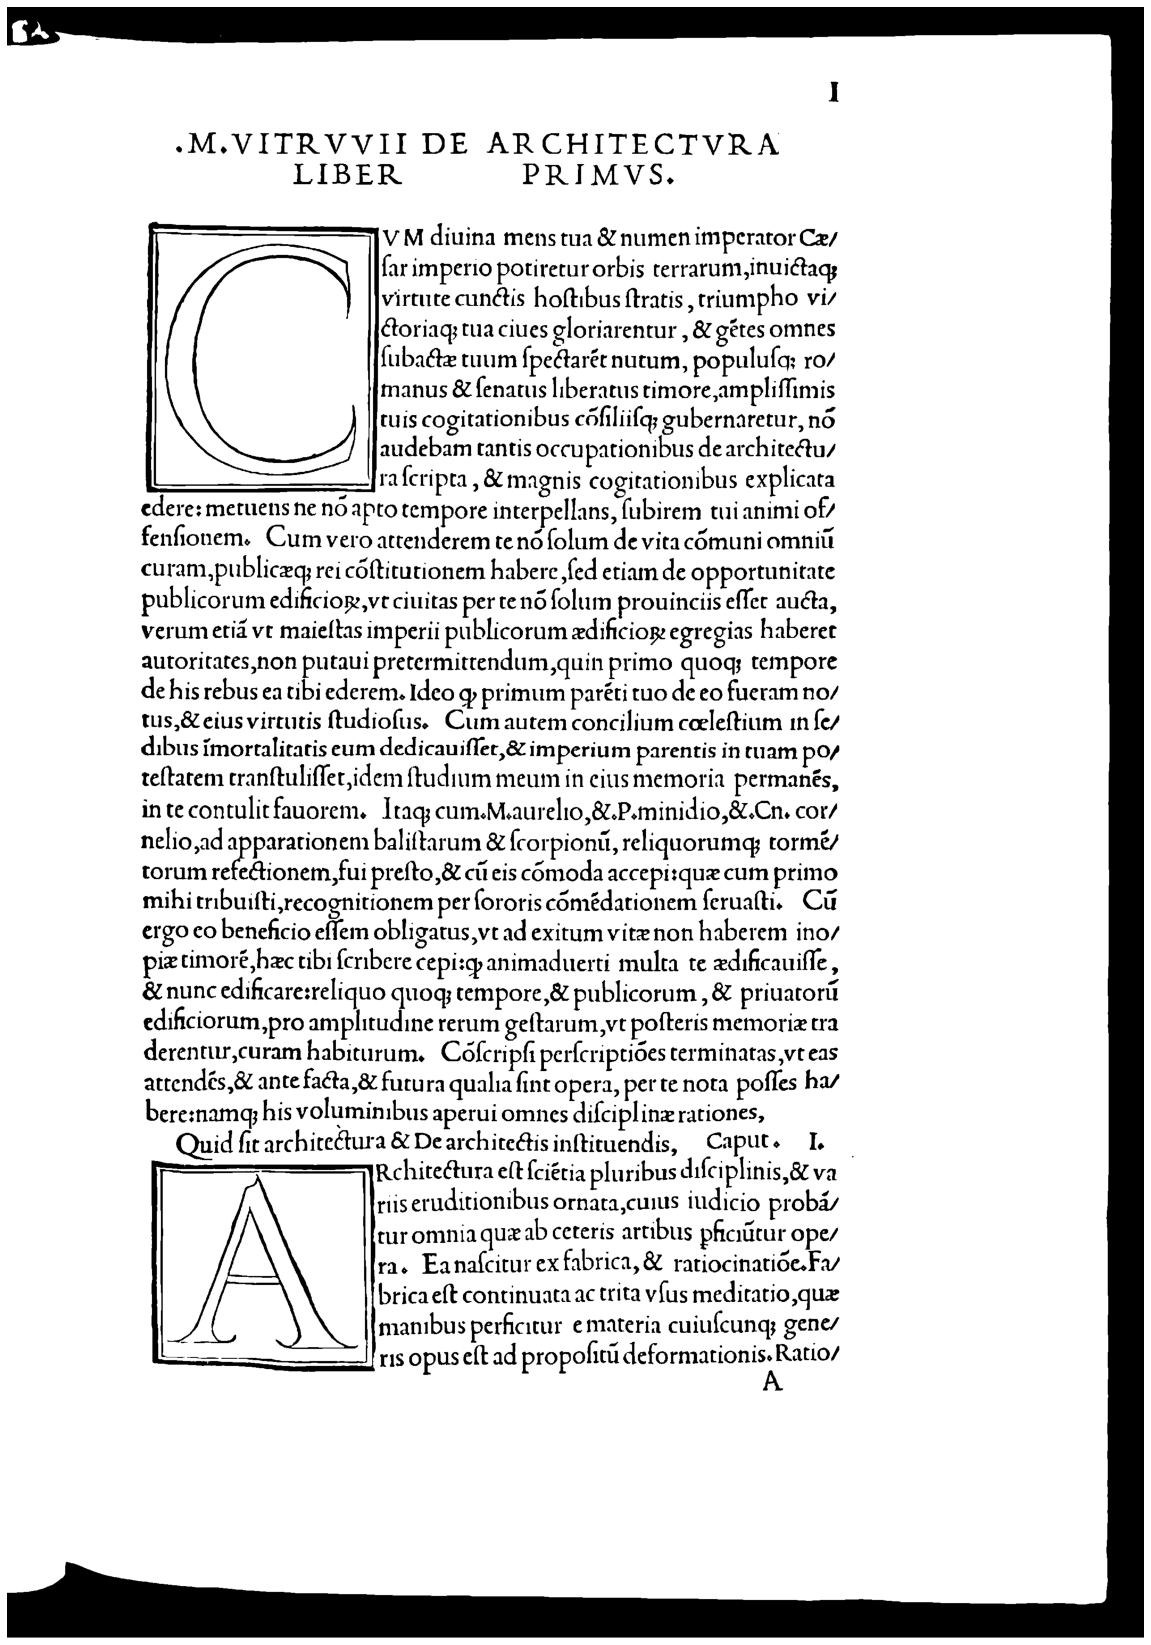

Extracted Text:
»-M.VITRVVII DE ARCHITECTVRA
LIBER PRIMVS.

VM diuina mens tua & numen imperator Cz/

far imperio potiretur orbis terrarum,inui@agg

virtue cunétis hoftibus ftratis , triumpho vis

Coriag tua ciues gloriarentur , & gétes omnes

{uba@e tuum fpeftarée nutum, populufa; ro/

manus & fenatus liberatus timore,ampliffimis

tuis cogitationibus cofiliifq; gubernaretur, nd

audebam tantis occupationibus de archite@us

—}rafcripta , & magnis cogitationibus explicata

edere: metuens ne no apto tempore interpellans, {ubirem tui animi off

fenfionem. Cum vero attenderem ten6 folum de vitac6muni omnitt

curam, publica rei c6ftitutionem habere fed etiam de opportunitate

publicorum edificioge,ve ciuitas per tend folum prouinciis effec auéta,

verum etia ve maieftas imperii publicorum edificiox egregias haberet

autoritates,non putaui precermittendum,quin primo quog; tempore

de his rebus ea tibi ederem. Ideo q primum paréti tuo de eo fueram nos

tus,& eiusvirtutis Qtudiofus. Cum autem 

In [131]:
compare_docs(binarized_1552, binarized_1511)

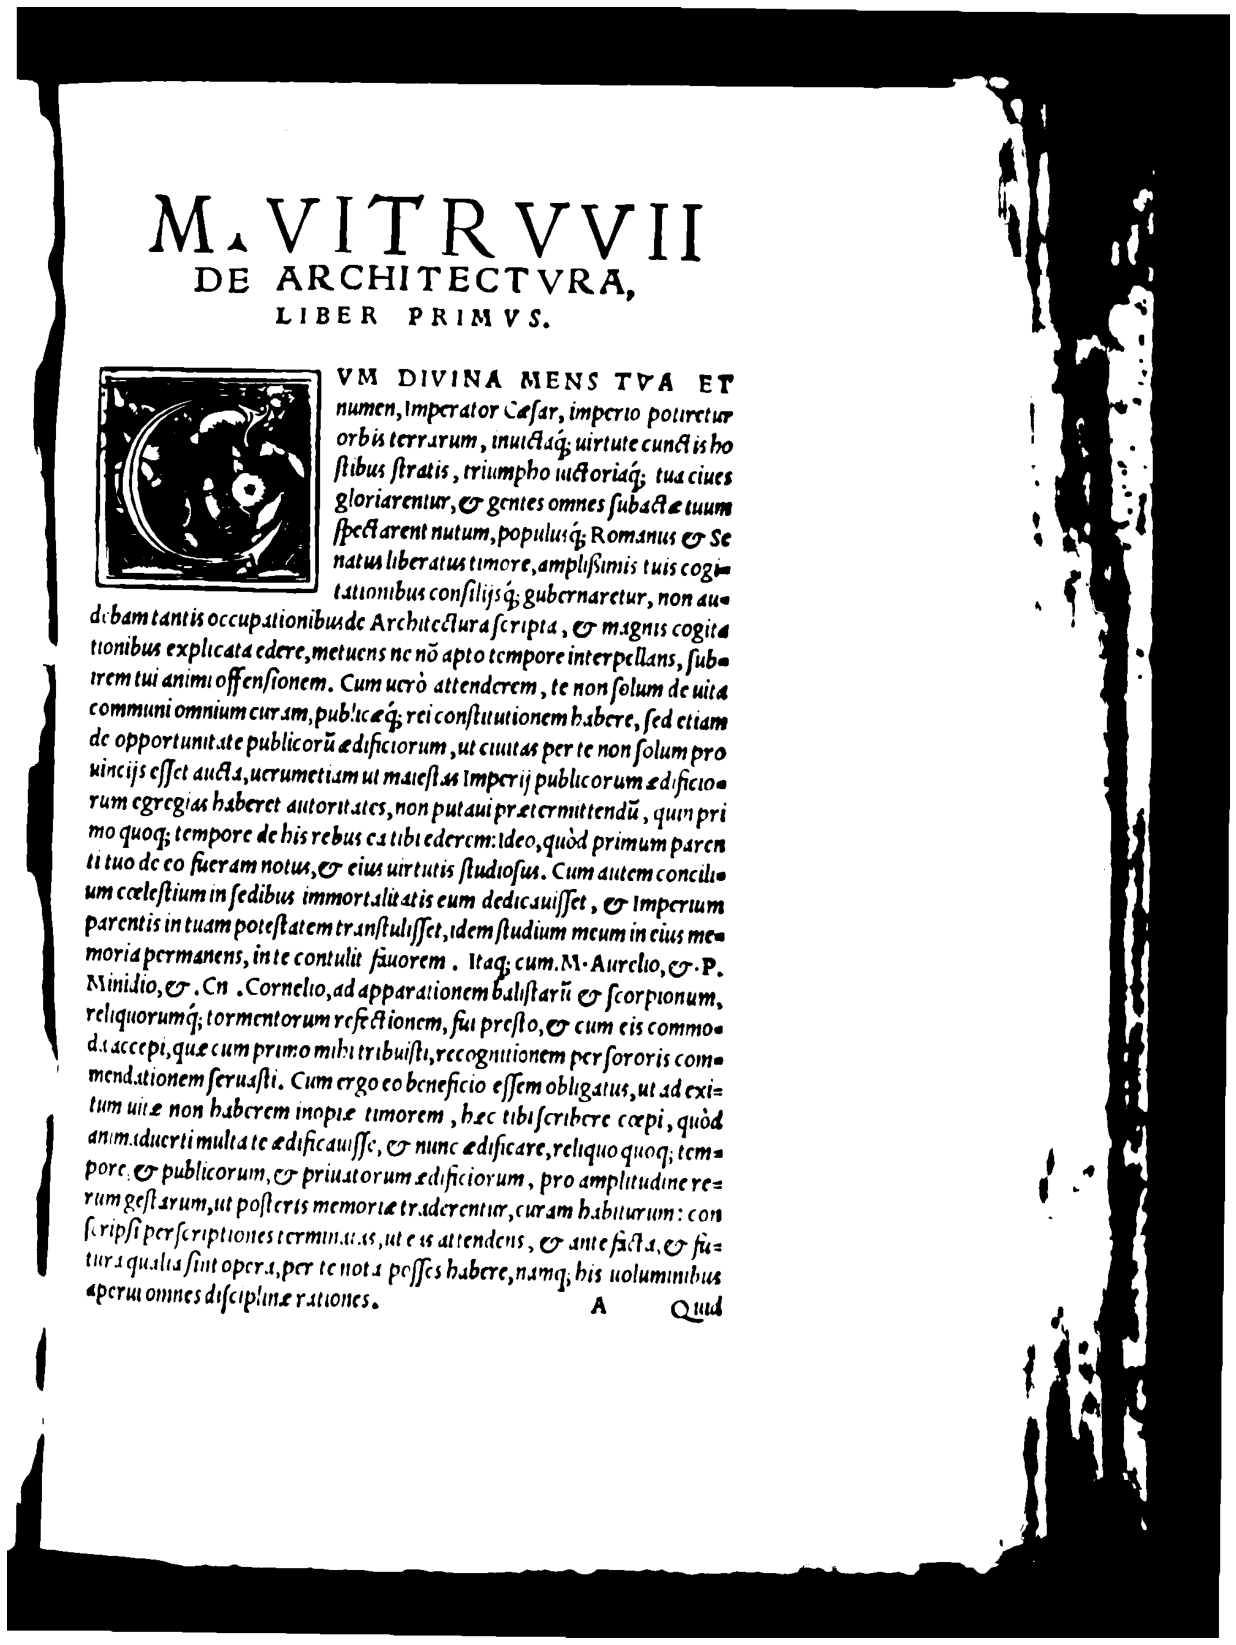

Extracted Text:
M.VITRVVII

DE ARCHITECTVRA,
LIBER PRIMVS,

VM DIVINA MENS TVA EP
numen, Imperator Cafar, impcrio potirctur
orbis terrarum, inuidag, uirtute cund is ho
flibus ftratis , rriumpbo woriag, tus ciues
gloriarentur, er gentes omnes fubste tuum
fbeA arent nutum, populusg; Romanus e Se
natus liberatus timore,amplifimis tuis cogbe
tatconibus con/ilijsg; gubernaretur, non aue
dcbam tantis occupationibusde Architellura [cripta , oF magnis cogita
tionibus explicata edere,metuens ne nd apto tempore interpcllans, fube
trem tut animioffenfionem, Cum ucro attendcrem, te non folum de uita
COMMUni Omnium cursm, publiceg, reiconftuutionem babere, fed ctiam
de opportunttate publicori edificiorum ,ut cuutas per tenon folum pro
mincijs effet auAs,ucrumetism ul matcfl.ss Imperij publicorum edificioe
rum egregias haberct autorit.stes,non putaui pretermittendiz, quin pri
mo quoq; tempore de his rebus ca tibtedercm: tdeo,quod primum paren
tituo deco fseram notus,er cius uirtutis ftudtofus. Cum a

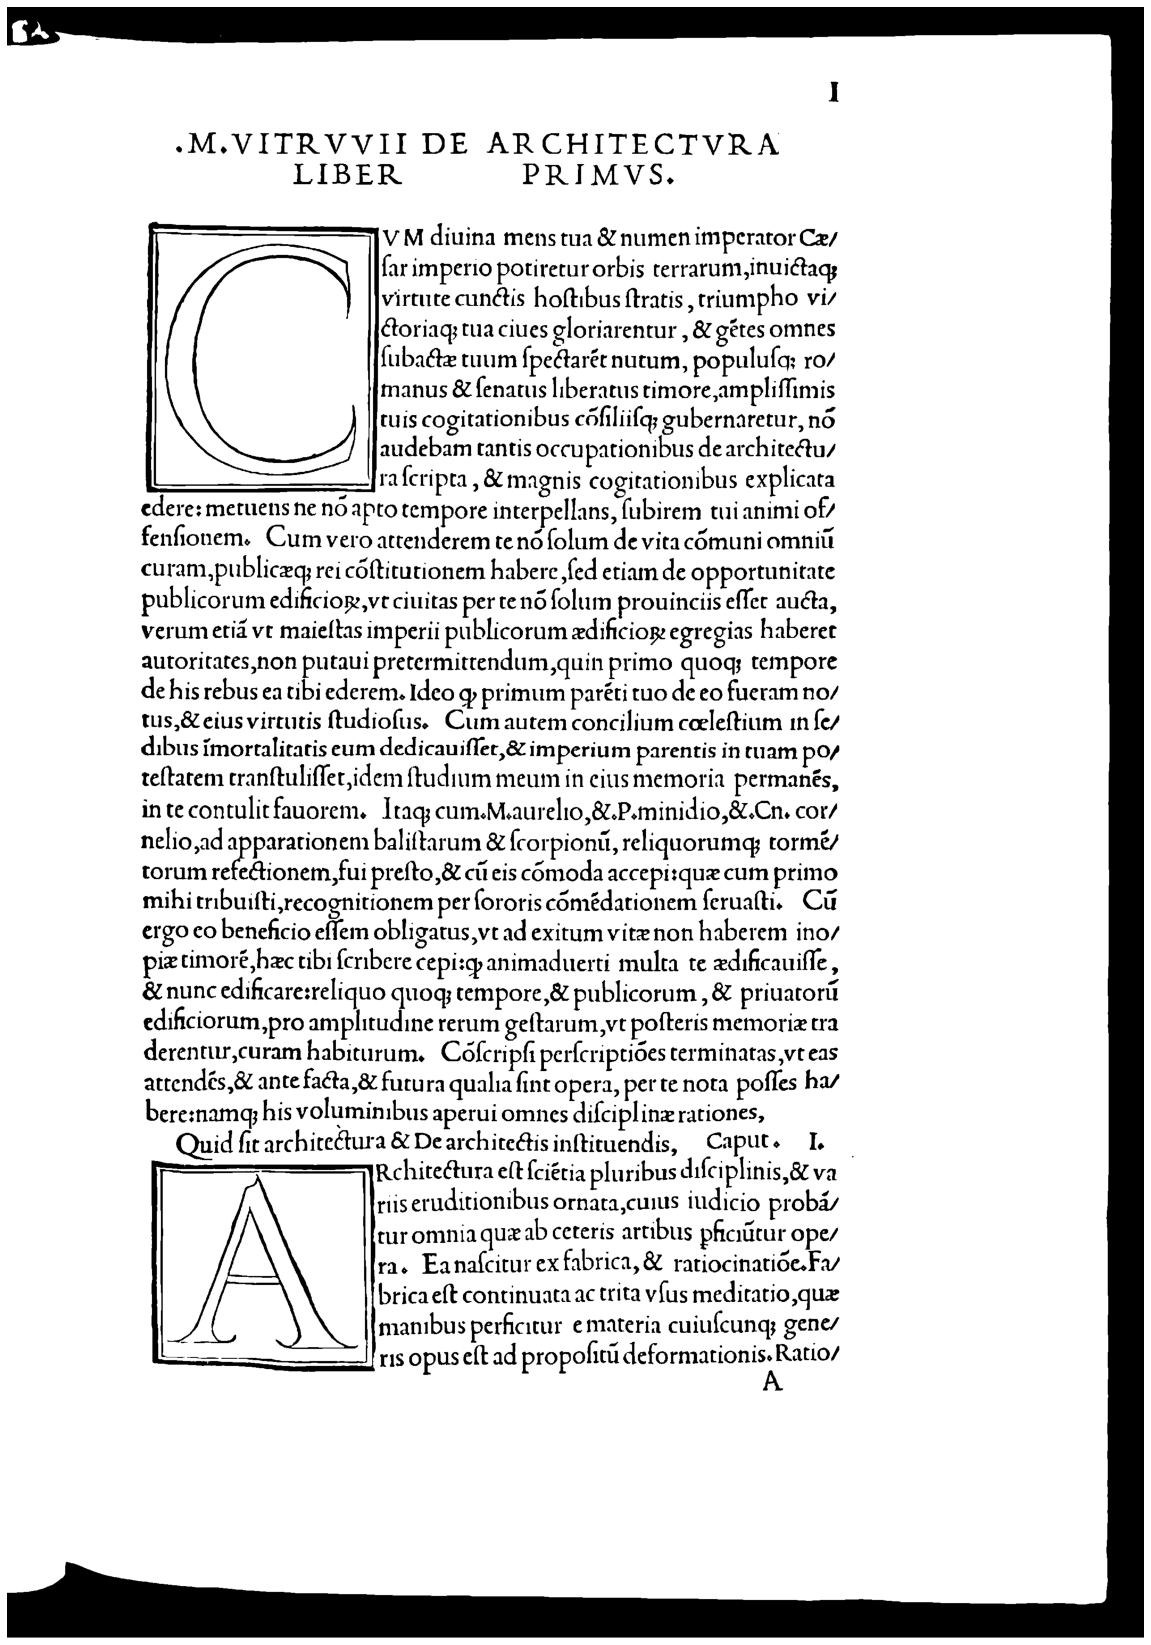

Extracted Text:
»-M.VITRVVII DE ARCHITECTVRA
LIBER PRIMVS.

VM diuina mens tua & numen imperator Cz/

far imperio potiretur orbis terrarum,inui@agg

virtue cunétis hoftibus ftratis , triumpho vis

Coriag tua ciues gloriarentur , & gétes omnes

{uba@e tuum fpeftarée nutum, populufa; ro/

manus & fenatus liberatus timore,ampliffimis

tuis cogitationibus cofiliifq; gubernaretur, nd

audebam tantis occupationibus de archite@us

—}rafcripta , & magnis cogitationibus explicata

edere: metuens ne no apto tempore interpellans, {ubirem tui animi off

fenfionem. Cum vero attenderem ten6 folum de vitac6muni omnitt

curam, publica rei c6ftitutionem habere fed etiam de opportunitate

publicorum edificioge,ve ciuitas per tend folum prouinciis effec auéta,

verum etia ve maieftas imperii publicorum edificiox egregias haberet

autoritates,non putaui precermittendum,quin primo quog; tempore

de his rebus ea tibi ederem. Ideo q primum paréti tuo de eo fueram nos

tus,& eiusvirtutis Qtudiofus. Cum autem 

In [132]:
compare_docs(binarized_1543, binarized_1511)